In [1]:
'''
This notebook will output a dataset .npy of Lagrangian particle flow map
Total particle number : Nx x Ny
Finite Time interval : t0 --> t0 + T (trajectory data during this T will not be saved)
Output variable : 2D numpy array of tuples;
                  Each tuple (x0, y0, x1, y1) stores initial and final positions of a Lagrangian particle,
                  i.e. r(t0) = (x0, y0) and r(t0+T) = (x1, y1)
''' 


import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi

from scipy import integrate
import scipy as sp

In [2]:
### create flow domain 
# there are same number of Lagrangian and Eulerian grid points (Nx, Ny)
Lx, Ly = (2, 2)
Nx, Ny = (150, 150)
x = np.linspace(-Lx,Lx,Nx)
y = np.linspace(-Ly,Ly,Ny)
X, Y = np.meshgrid(x,y)
dx = Lx/(Nx-1)
dy = dx
if np.any(y == 0):
    raise ValueError("Zero found in the y(r) coordinates")
X, Y = np.meshgrid(x, y)
rad_dist = np.sqrt(X**2 + Y**2)

# define parameters
alpha = 1
a = 1

# integration time
t0 = 0
tf = 30

# define velocity fields
Uf_field = np.empty_like(X)
Uf_field[rad_dist < a] = alpha * (a**2 - rad_dist[rad_dist < a]**2 - Y[rad_dist < a]**2) / 5
Uf_field[rad_dist > a] = -alpha * a**2 * ( 2*(1 - a**3 / rad_dist[rad_dist > a]**3) + 3*a**3*Y[rad_dist > a]**2/rad_dist[rad_dist > a]**3 ) / 15

Vf_field = np.empty_like(X)
Vf_field[rad_dist < a] = alpha * X[rad_dist < a] * Y[rad_dist < a] / 5
Vf_field[rad_dist > a] = alpha* a**5 * Y[rad_dist > a] * X[rad_dist > a] / ( 5*(rad_dist[rad_dist > a] ** 3))

In [13]:
#### compute particle trajectories

# inertial particle parameters in the MR equation
St = 0.2 * np.ones_like(X)
St[int((Ny-1)/2):, :] = 1
R = 1
W = -0.2

# Solve the IVP RK4 -- for inertial particles
def solve_ivp_active(Lag_point, t0 = t0, tf = tf):
  '''
  Assuming that the inertial particles follow flow field before integrating path, i.e. only released at t0
  '''
  
  # define the IVP to solve -- for INERTIAL particles

  t_span = np.linspace(t0,tf,500)

  def active_tracer_traj(t, Z, St) :
    # state-space vector Z[2] is vx, Z[3] is vy
      # compute flow field at particle position (xp, yp)
      xp = Z[0]
      yp = Z[1]
      dist = np.sqrt(xp**2 + yp**2)

      if dist <= a:
            Uf = alpha * (a**2 - dist**2 - yp**2) / 5
            Vf = alpha * xp * yp / 5
            dUdt = 0
            dVdt = 0
            dUdx = -2 * alpha * xp / 5
            dUdy = -4 * alpha * yp / 5
            dVdx = alpha * yp / 5
            dVdy = alpha * xp / 5


      else :
            Uf = -alpha * a**2 * ( 2*(1 - a**3 / dist**3) + 3* a**3 * yp**2 / dist**3 ) / 15
            Vf = alpha* a**5 * yp * xp/ ( 5*(dist ** 3))
            dUdt = 0
            dVdt = 0
            dUdx = alpha * a**5 * (3*yp**2 - 2) * xp / (5*dist**3)
            dUdy = alpha * a**5 * yp * (yp**2 -2*xp**2 - 2) * xp / (5*dist**5)
            dVdx = - alpha * a**5 * (2*(xp**2)*yp - yp**3) / (5*dist**5)
            dVdy = - alpha * a**5 * (2*(yp**2)*xp - xp**3) / (5*dist**5)



      # define derivatives
      dxpdt = Z[2]  # vx
      dypdt = Z[3]  # vy
      ddxpdtt = (Uf - dxpdt)/St + (3*R/2) * (dUdt + Uf*dUdx + Vf*dUdy)
      ddypdtt = (Vf - dypdt)/St + (3*R/2) * (dVdt + Uf*dVdx + Vf*dVdy) - W
      return [dxpdt, dypdt, ddxpdtt, ddypdtt]


  x0, y0 = Lag_point
  xi = int(np.where(x==x0)[0])
  yj = int(np.where(y==y0)[0])
  St_i = St[yj, xi]
  sol = sp.integrate.solve_ivp(active_tracer_traj, [t0, tf], [x0, y0, Uf_field[yj, xi], Vf_field[yj, xi]], t_eval=t_span, vectorized=True, args=(St_i,))
  xpt, ypt = sol.y[0], sol.y[1]
  return xpt, ypt

  
  

In [14]:
### compute the INTERTIAL particle flow map in the whole domain

# create a flattened array of grid points, first index is x
grid_coords = np.column_stack((X.ravel(), Y.ravel()))
final_coords = np.empty_like(grid_coords, dtype=object)


# ## the slow version
# for i, _ in enumerate(grid_coords):
#     x0, y0 = grid_coords[i, 0], grid_coords[i, 1]
#     rt = solve_ivp_active((x0, y0))
#     final_coords[i,:] = rt[0][-1], rt[1][-1]

## using multiprocessing
'''
output [res], a list with len = Nx*Ny, 
each list element is an array of t_span for one particle
'''
from multiprocessing import Pool

n_proc = 12
with Pool(n_proc) as pool:
    args = list( grid_coords )
    res = pool.map( solve_ivp_active, args )

final_coords = np.array([(point[0][-1], point[1][-1]) for point in res], dtype=float)



## construct flow map of positions at t0 and tf
flow_map = np.column_stack((grid_coords, final_coords))
# np.save(f'hills_i_W_{W}_St{St}_R{R}_tf{tf}.npy', flow_map)

# np.savez_compressed(f'FULL_hills_i_W{W}_St{St}_R{R}_tf{tf}.npz', data=np.array(res))

In [15]:
case = 1
np.save(f'hills_i_W_{W}_caseSt{case}_R{R}_tf{tf}.npy', flow_map)

np.savez_compressed(f'FULL_hills_i_W{W}_caseSt{case}_R{R}_tf{tf}.npz', data=np.array(res))

In [16]:
# this is a 3D array and the first two indicies are the particle "Name" (defined by its initial position)
flow_map_arr = np.array([tuple(row) for row in flow_map]).reshape((Ny, Nx, 4))
X0 = flow_map_arr[:,:,0]
Y0 = flow_map_arr[:,:,1]
Xf = flow_map_arr[:,:,2]
Yf = flow_map_arr[:,:,3]

In [17]:
def compute_ftle(xi, yj, t0, tf):

    """
    the arguments xi, yj are indices, not coordinates
    """

    D = np.zeros((2,2))   # 2D deformation gradient matrix
    D[0,0] = (Xf[yj, xi+1] - Xf[yj, xi-1]) / (X0[yj, xi+1] - X0[yj, xi-1])
    D[0,1] = (Xf[yj+1, xi] - Xf[yj-1, xi]) / (Y0[yj+1, xi] - Y0[yj-1, xi])
    D[1,0] = (Yf[yj, xi+1] - Yf[yj, xi-1]) / (X0[yj, xi+1] - X0[yj, xi-1])
    D[1,1] = (Yf[yj+1, xi] - Yf[yj-1, xi]) / (Y0[yj+1, xi] - Y0[yj-1, xi])

    CGDtensor = D.T @ D # symmetric square real matrix must have orthogonal eigenvectors,  the SV's are the absolute values of the eigenvalues
    # _, SV, _ = np.linalg.svd(CGDtensor, hermitian=True)

    _, SV, _ = np.linalg.svd(D)

    if SV[0] < 1:
        SV = np.ones_like(SV)
    else:
        SV[1] = 1/SV[0]

    ftle = np.log(SV[0]) / np.abs(tf-t0)
    
    return ftle

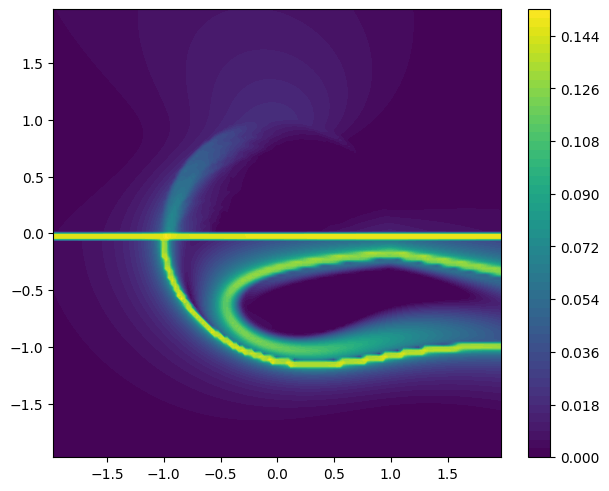

In [18]:
FTLE_field = np.empty((Ny-2, Nx-2))
# FTLE_field = np.empty((Ny, Nx))


for xi in range(Nx-2) :
    for yj in range(Ny-2) :
        FTLE_field[yj, xi] = compute_ftle((xi+1), (yj+1), t0, tf)

# for xi in range(1, Nx-1) :
#     for yj in range(1, Ny-1) :
#         FTLE_field[yj, xi] = compute_ftle(xi, yj, t0, tf)



fig, ax = plt.subplots(layout='constrained')
CS = ax.contourf(X[1:-1, 1:-1], Y[1:-1, 1:-1], FTLE_field, 50)
ax.set_aspect('equal')
cbar = fig.colorbar(CS)

In [10]:
# np.savez_compressed(f'FULL_hills_i_W{W}_St{St}_R{R}_tf{tf}.npz', data=np.array(res))
